In [1]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import isotropic1024coarse as info

import pickle
import time

In [2]:
npoints = 10
nparticles = 1000
nsteps = info['time'].shape[0] #total of 124

x0 = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = info['lx']*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = info['ynodes'][info['ynodes'].shape[0]//2]
x0[..., 2] = info['lz']*np.random.random(size = (npoints,))[:, None]

nu = info['nu']
energy_diss = info['diss']

kolmogorov_time = (nu/energy_diss)**.5
kolmogorov_length = nu**(3/4.)*energy_diss**(-1/4.)

T = info['time'][-1];
subdivisions = 2
t = np.linspace(info['time'][-1], info['time'][0], num = subdivisions*nsteps + 1)
tau = t[0]-t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5



trytimes = [1,3,10,30,100,300,1000] #waiting times in case database fails   

#x0 = pickle.load( open( "data_isotropic/x0.p", "rb" ) )
#x0 = x0[:,0:nparticles,:]

In [6]:
PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
for m in range(PrandtlNumbers.shape[0]): 
    xfull  = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles, 3), dtype = np.float32)
    xfull[0] = x0.copy()
    
    Prandtl = np.float(PrandtlNumbers[m])
    kappa = nu/Prandtl
    noiseamplitude  = (2*kappa)**.5
    
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    for tindex in range(subdivisions*nsteps):
        print('step {0} of {1} for Pr = {2}'.format(tindex, subdivisions*nsteps, Prandtl))
        
        for tryT in trytimes:  
            try:
                u = lJHTDB.getData(
                            t[tindex],
                            xfull[tindex],
                            sinterp = interpolation_code['M2Q8'],
                            tinterp = interpolation_code['NoTInt'],
                            data_set = info['name'],
                            getFunction = 'getVelocity')
                break
            except Exception as e:
                print e
                time.sleep(tryT)                
        dW = np.random.randn(*xfull.shape[1:])*sqrtdt
        dX = -u*dt + noiseamplitude*dW
        xfull[tindex + 1] = xfull[tindex] + dX
    lJHTDB.finalize()

    ####### Dump Data #######
    suffix = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
    pickle.dump(xfull,    open( "data_isotropic/xfull"    + suffix, "wb" ) )
    pickle.dump(t,        open( "data_isotropic/tfull"    + suffix, "wb" ) )

step 0 of 2048 for Pr = 10.0
step 1 of 2048 for Pr = 10.0
step 2 of 2048 for Pr = 10.0


KeyboardInterrupt: 

In [7]:
####### Load Data #######
PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
nparticles = 100
Prandtl1 = PrandtlNumbers[0]
Prandtl2 = PrandtlNumbers[1]
Prandtl3 = PrandtlNumbers[2]
suffix1 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
suffix2 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl2)
suffix3 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl3)

t     = pickle.load( open( "data_isotropic/t"       + suffix1, "rb" ) )
xfull1 = pickle.load( open( "data_isotropic/xfull"    + suffix1, "rb" ) )
xfull2 = pickle.load( open( "data_isotropic/xfull"    + suffix2, "rb" ) )
xfull3 = pickle.load( open( "data_isotropic/xfull"    + suffix3, "rb" ) )

<IPython.core.display.Javascript object>


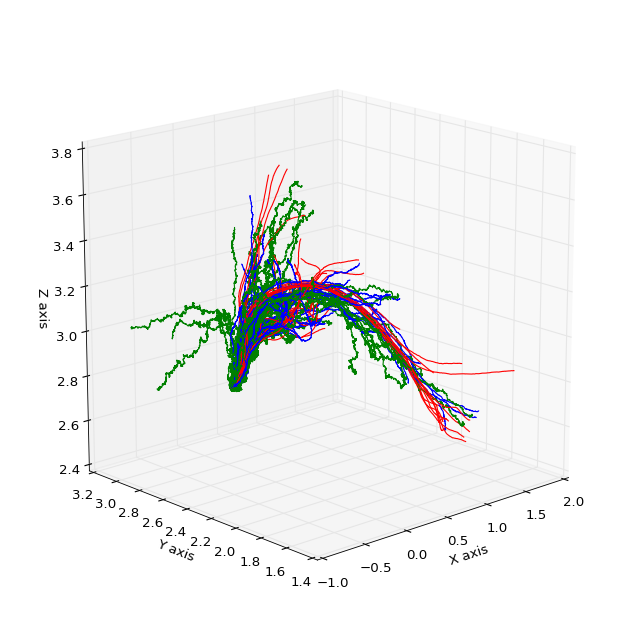

In [49]:
molecular_traj1 = xfull1
molecular_traj2 = xfull2
molecular_traj3 = xfull3
space_index = 5
num_parts = 3
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')
for traj in range(0,molecular_traj1.shape[2],num_parts):
    ax.plot(molecular_traj1[:, space_index, traj, 0],
            molecular_traj1[:, space_index, traj, 1],
            molecular_traj1[:, space_index, traj, 2],
            color = 'red', label = '$Pr = {0}$'.format(Prandtl1))
    ax.plot(molecular_traj2[:, space_index, traj, 0],
            molecular_traj2[:, space_index, traj, 1],
            molecular_traj2[:, space_index, traj, 2],
            color = 'blue',  label = '$Pr = {0}$'.format(Prandtl2))
    ax.plot(molecular_traj3[:, space_index, traj, 0],
            molecular_traj3[:, space_index, traj, 1],
            molecular_traj3[:, space_index, traj, 2],
            color = 'green', label = '$Pr = {0}$'.format(Prandtl3))

#ax.set_xlim3d(0 , 8*np.pi)
#ax.set_ylim3d(-Ly/2, Ly/2)
#ax.set_zlim3d(0, 3*np.pi)

#ax.title('Noisy Lagrangian Trajectories')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

<IPython.core.display.Javascript object>


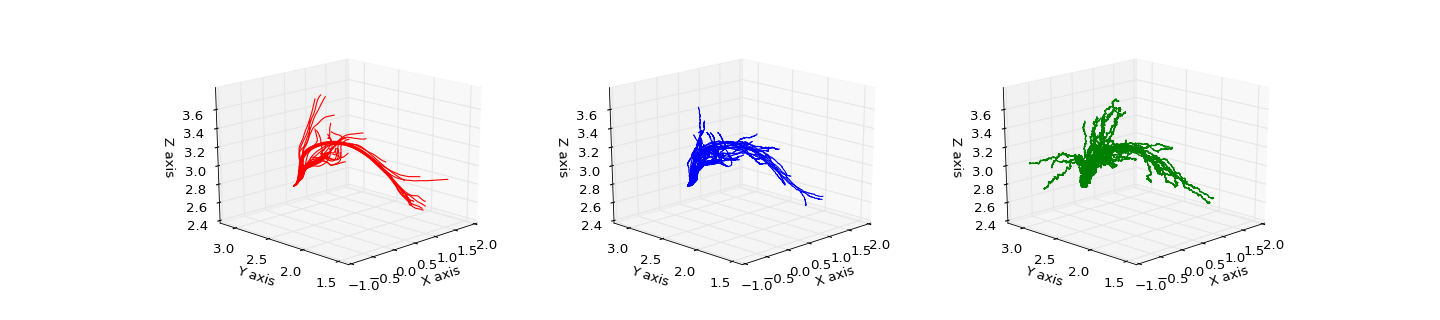

In [84]:
space_indx = 5
num_parts = 3
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(131, projection = '3d')
ax2 = fig.add_subplot(132, projection = '3d')
ax3 = fig.add_subplot(133, projection = '3d')
for traj in range(0,xfull1.shape[2],num_parts):
    ax1.plot(xfull1[:, space_indx, traj, 0],
             xfull1[:, space_indx, traj, 1],
             xfull1[:, space_indx, traj, 2],
             color = 'red')
for traj in range(0,xfull2.shape[2],num_parts):
    ax2.plot(xfull2[:, space_indx, traj, 0],
             xfull2[:, space_indx, traj, 1],
             xfull2[:, space_indx, traj, 2],
             color = 'blue')
for traj in range(0,xfull3.shape[2],num_parts):
    ax3.plot(xfull3[:, space_indx, traj, 0],
             xfull3[:, space_indx, traj, 1],
             xfull3[:, space_indx, traj, 2],
             color = 'green')
    
ax1.set_xlim3d(-1 , 2)
ax1.set_ylim3d(1.4, 3.2)
ax1.set_zlim3d(2.4, 3.8)
ax2.set_xlim3d(-1 , 2)
ax2.set_ylim3d(1.4, 3.2)
ax2.set_zlim3d(2.4, 3.8)
ax3.set_xlim3d(-1 , 2)
ax3.set_ylim3d(1.4, 3.2)
ax3.set_zlim3d(2.4, 3.8)

ang = -135
ax1.view_init(20, ang)
ax2.view_init(20, ang)
ax3.view_init(20, ang)

ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Z axis')
ax3.set_xlabel('X axis')
ax3.set_ylabel('Y axis')
ax3.set_zlabel('Z axis')

In [62]:
####### Load Data #######
PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
nparticles = 1000
Prandtl1 = PrandtlNumbers[0]
Prandtl2 = PrandtlNumbers[1]
Prandtl3 = PrandtlNumbers[2]
suffix1 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
suffix2 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl2)
suffix3 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl3)

t     = pickle.load( open( "data_isotropic/t"       + suffix1, "rb" ) )
disp1 = pickle.load( open( "data_isotropic/disp"    + suffix1, "rb" ) )
disp2 = pickle.load( open( "data_isotropic/disp"    + suffix2, "rb" ) )
disp3 = pickle.load( open( "data_isotropic/disp"    + suffix3, "rb" ) )

<IPython.core.display.Javascript object>


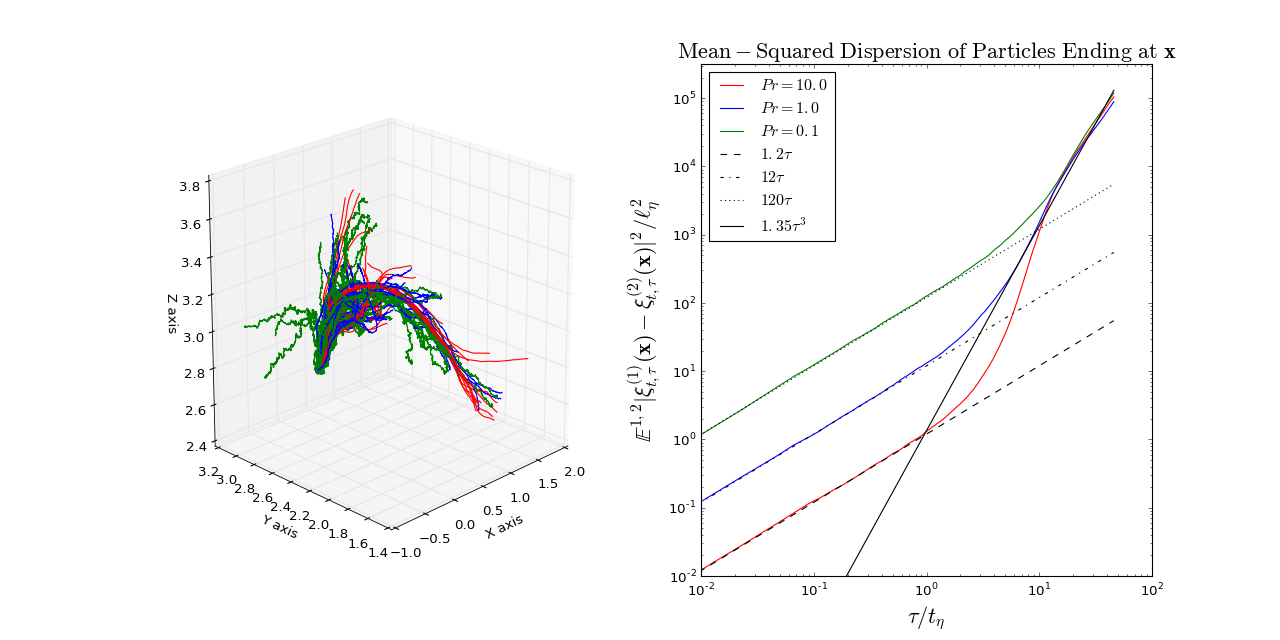

In [66]:
space_point_index = 5

Tau = tau/float(kolmogorov_time)
diffusion_dispersion1 = 12*Tau/Prandtl1
diffusion_dispersion2 = 12*Tau/Prandtl2
diffusion_dispersion3 = 12*Tau/Prandtl3
Richardson_dispersion = (1.35)*Tau**3

disper1 = disp1[:,space_point_index]/float(kolmogorov_length**2)
disper2 = disp2[:,space_point_index]/float(kolmogorov_length**2)
disper3 = disp3[:,space_point_index]/float(kolmogorov_length**2)


molecular_traj1 = xfull1
molecular_traj2 = xfull2
molecular_traj3 = xfull3
space_index = 5
num_parts = 3

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection = '3d')
for traj in range(0,molecular_traj1.shape[2],num_parts):
    ax.plot(molecular_traj1[:, space_index, traj, 0],
            molecular_traj1[:, space_index, traj, 1],
            molecular_traj1[:, space_index, traj, 2],
            color = 'red', label = '$Pr = {0}$'.format(Prandtl1))
    ax.plot(molecular_traj2[:, space_index, traj, 0],
            molecular_traj2[:, space_index, traj, 1],
            molecular_traj2[:, space_index, traj, 2],
            color = 'blue',  label = '$Pr = {0}$'.format(Prandtl2))
    ax.plot(molecular_traj3[:, space_index, traj, 0],
            molecular_traj3[:, space_index, traj, 1],
            molecular_traj3[:, space_index, traj, 2],
            color = 'green', label = '$Pr = {0}$'.format(Prandtl3))

#ax.set_xlim3d(0 , 8*np.pi)
#ax.set_ylim3d(-Ly/2, Ly/2)
#ax.set_zlim3d(0, 3*np.pi)

#ax.title('Noisy Lagrangian Trajectories')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax2 = fig.add_subplot(122)
ax2.plot(Tau, disper1, color = 'red', linestyle = 'solid',  label = '$Pr = {0}$'.format(Prandtl1))
ax2.plot(Tau, disper2, color = 'blue', linestyle = 'solid', label = '$Pr = {0}$'.format(Prandtl2))
ax2.plot(Tau, disper3, color = 'green',     linestyle = 'solid',  label = '$Pr = {0}$'.format(Prandtl3))
ax2.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed',  label = '$1.2 \\tau$')
ax2.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$12 \\tau$')
ax2.plot(Tau, diffusion_dispersion3,   color = 'black', linestyle = 'dotted',  label = '$120 \\tau$')
ax2.plot(Tau, Richardson_dispersion,   color = 'black', linestyle = 'solid',   label = '$1.35 \\tau^3$')
ax2.set_ylim([10**(-2),10**(5.5)])
ax2.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax2.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax2.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /\\ell_\\eta^2$', fontsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend(loc ="best")

In [ ]:
molecular_traj = xfull3
trajUsed = range(0,nparticles,10)
T = np.array(trajUsed)
r = np.zeros((timeline.shape[0],npoints,nparticles,nparticles))
for k in range(npoints):
    for i in trajUsed:
        for j in trajUsed:
            if i<j:
                 r[:,k,i,j] =   (molecular_traj[:, k, i, 0] - molecular_traj[:, k, j, 0])**2\
                              + (molecular_traj[:, k, i, 1] - molecular_traj[:, k, j, 1])**2\
                              + (molecular_traj[:, k, i, 2] - molecular_traj[:, k, j, 2])**2
                            
numcombs =  nparticles*(nparticles-1)/2
tau = (timeline[0] - timeline)/kolmogorov_time
mean_square_dispersion = np.sum(np.sum(r, axis=3),axis=2)/numcombs
mean_square_dispersion_space_Ave = np.sum(np.sum(np.sum(r, axis=3),axis=2),axis=1)/(numcombs*npoints)
mean_square_dispersion = mean_square_dispersion/(kolmogorov_length**2)
mean_square_dispersion_space_Ave = mean_square_dispersion_space_Ave/(kolmogorov_length**2)

<IPython.core.display.Javascript object>


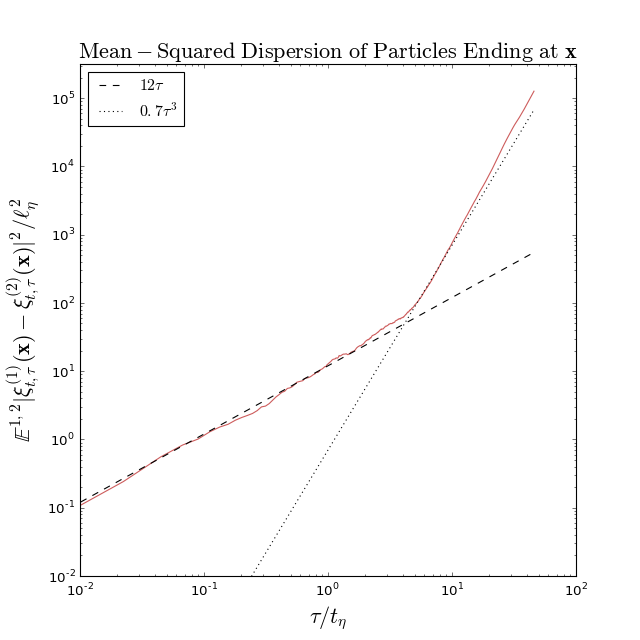

In [18]:
diffusion_dispersion = 12*tau/Prandtl
Richardson_dispersion = 0.7*tau**3

space_point_index = 6
dispersion = mean_square_dispersion[:,space_point_index]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau, dispersion, color = 'Indianred')
ax.plot(tau, diffusion_dispersion,   color = 'black', linestyle = 'dashed', label = '$12 \\tau$')
ax.plot(tau, Richardson_dispersion,  color = 'black', linestyle = 'dotted', label = '$0.7 \\tau^3$')
ax.set_ylim([10**(-2),10**(5.5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /\\ell_\\eta^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")